In [1]:
""" Imports from qiskit"""
from qiskit import *

from qiskit.tools.visualization import plot_histogram

import sys

""" Imports to Python functions """
import math
import array
import fractions
import numpy as np

%matplotlib inline

In [2]:
def check_if_power(N):
    b=2
    while (2**b) <= N:
        a = 1
        c = N
        while (c-a) >= 2:
            m = int( (a+c)/2 )

            if (m**b) < (N+1):
                p = int( (m**b) )
            else:
                p = int(N+1)

            if int(p) == int(N):
                print('N is {0}^{1}'.format(int(m),int(b)) )
                return True

            if p<N:
                a = int(m)
            else:
                c = int(m)
        b=b+1

    return False

""" Function to get the value a ( 1<a<N ), such that a and N are coprime. Starts by getting the smallest a possible
    This normally is be done fully randomly, we just did like this for user (professor) to have complete control 
    over the a value that gets selected """
def get_value_a(N):
    ok='0'
    a=2
    while math.gcd(a,N)!=1:
        a=a+1
    smallest_a = a
    ok = input('Is the number {0} ok for a? Press 0 if not, other number if yes: '.format(a))
    if ok=='0':
        if(N==3):
            print('Number {0} is the only one you can use. Using {1} as value for a\n'.format(a,a))
            return a
        a=a+1

    while ok=='0':
        while math.gcd(a,N)!=1:
            a=a+1

    """ Print the value that is used as a """
    print('Using {0} as value for a\n'.format(a))

    return a

""" Function to apply the continued fractions to find r and the gcd to find the desired factors"""
def get_factors(x_value,t_upper,N,a):
    if x_value<=0:
        print('x_value is <= 0, there are no continued fractions\n')
        return False
    print('Running continued fractions for this case\n')
    
    T = pow(2,t_upper)

    x_over_T = x_value/T

    i=0
    b = array.array('i')
    t = array.array('f')
    b.append(math.floor(x_over_T))
    t.append(x_over_T - b[i])
    while i>=0:

        if i>0:
            b.append( math.floor( 1 / (t[i-1]) ) ) 
            t.append( ( 1 / (t[i-1]) ) - b[i] )
        """ Calculate the CF using the known terms """
        aux = 0
        j=i
        while j>0:    
            aux = 1 / ( b[j] + aux )      
            j = j-1
        aux = aux + b[0]
        """Get the denominator from the value obtained"""
        frac = fractions.Fraction(aux).limit_denominator()
        den=frac.denominator
        print('Approximation number {0} of continued fractions:'.format(i+1))
        print("Numerator:{0} \t\t Denominator: {1}\n".format(frac.numerator,frac.denominator))
        """ Increment i for next iteration """
        i=i+1
        if (den%2) == 1:
            if i>=15:
                print('Returning because have already done too much tries')
                return False
            print('Odd denominator, will try next iteration of continued fractions\n')
            continue
        """ If denominator even, try to get factors of N """
        """ Get the exponential a^(r/2) """
        exponential = 0
        if den<1000:
            exponential=pow(a , (den/2))
        
        """ Check if the value is too big or not """
        if math.isinf(exponential)==1 or exponential>1000000000:
            print('Denominator of continued fraction is too big!\n')
            aux_out = input('Input number 1 if you want to continue searching, other if you do not: ')
            if aux_out != '1':
                return False
            else:
                continue

        """If the value is not to big (infinity), then get the right values and
        do the proper gcd()"""

        putting_plus = int(exponential + 1)

        putting_minus = int(exponential - 1)
    
        one_factor = math.gcd(putting_plus,N)
        other_factor = math.gcd(putting_minus,N)
    
        """ Check if the factors found are trivial factors or are the desired
        factors """

        if one_factor==1 or one_factor==N or other_factor==1 or other_factor==N:
            print('Found just trivial factors, not good enough\n')
            """ Check if the number has already been found, use i-1 because i was already incremented """
            if t[i-1]==0:
                print('The continued fractions found exactly x_final/(2^(2n)) , leaving funtion\n')
                return False
            if i<15:
                aux_out = input('Input number 1 if you want to continue searching, other if you do not: ')
                if aux_out != '1':
                    return False       
            else:
                """ Return if already too much tries and numbers are huge """ 
                print('Returning because have already done too many tries\n')
                return False         
        else:
            print('The factors of {0} are {1} and {2}\n'.format(N,one_factor,other_factor))
            print('Found the desired factors!\n')
            return True

def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = egcd(b % a, a)
        return (g, x - (b // a) * y, y)
def modinv(a, m):
    g, x, y = egcd(a, m)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return x % m

""" Function to create QFT """
def create_QFT(circuit,up_reg,n,with_swaps):
    i=n-1
    """ Apply the H gates and Cphases"""
    """ The Cphases with |angle| < threshold are not created because they do 
    nothing. The threshold is put as being 0 so all CPhases are created,
    but the clause is there so if wanted just need to change the 0 of the
    if-clause to the desired value """
    while i>=0:
        circuit.h(up_reg[i])        
        j=i-1  
        while j>=0:
            if (np.pi)/(pow(2,(i-j))) > 0:
                circuit.cu1( (np.pi)/(pow(2,(i-j))) , up_reg[i] , up_reg[j] )
                j=j-1   
        i=i-1  

    """ If specified, apply the Swaps at the end """
    if with_swaps==1:
        i=0
        while i < ((n-1)/2):
            circuit.swap(up_reg[i], up_reg[n-1-i])
            i=i+1

""" Function to create inverse QFT """
def create_inverse_QFT(circuit,up_reg,n,with_swaps):
    """ If specified, apply the Swaps at the beggining"""
    if with_swaps==1:
        i=0
        while i < ((n-1)/2):
            circuit.swap(up_reg[i], up_reg[n-1-i])
            i=i+1
    
    """ Apply the H gates and Cphases"""
    """ The Cphases with |angle| < threshold are not created because they do 
    nothing. The threshold is put as being 0 so all CPhases are created,
    but the clause is there so if wanted just need to change the 0 of the
    if-clause to the desired value """
    i=0
    while i<n:
        circuit.h(up_reg[i])
        if i != n-1:
            j=i+1
            y=i
            while y>=0:
                 if (np.pi)/(pow(2,(j-y))) > 0:
                    circuit.cu1( - (np.pi)/(pow(2,(j-y))) , up_reg[j] , up_reg[y] )
                    y=y-1   
        i=i+1

"""Function that calculates the array of angles to be used in the addition in Fourier Space"""
def getAngles(a,N):
    s=bin(int(a))[2:].zfill(N) 
    angles=np.zeros([N])
    for i in range(0, N):
        for j in range(i,N):
            if s[j]=='1':
                angles[N-i-1]+=math.pow(2, -(j-i))
        angles[N-i-1]*=np.pi
    return angles

"""Creation of a doubly controlled phase gate"""
def ccphase(circuit,angle,ctl1,ctl2,tgt):
    circuit.cu1(angle/2,ctl1,tgt)
    circuit.cx(ctl2,ctl1)
    circuit.cu1(-angle/2,ctl1,tgt)
    circuit.cx(ctl2,ctl1)
    circuit.cu1(angle/2,ctl2,tgt)

"""Creation of the circuit that performs addition by a in Fourier Space"""
"""Can also be used for subtraction by setting the parameter inv to a value different from 0"""
def phiADD(circuit,q,a,N,inv):
    angle=getAngles(a,N)
    for i in range(0,N):
        if inv==0:
            circuit.u1(angle[i],q[i])
        else:
            circuit.u1(-angle[i],q[i])

"""Single controlled version of the phiADD circuit"""
def cphiADD(circuit,q,ctl,a,n,inv):
    angle=getAngles(a,n)
    for i in range(0,n):
        if inv==0:
            circuit.cu1(angle[i],ctl,q[i])
        else:
            circuit.cu1(-angle[i],ctl,q[i])

"""Doubly controlled version of the phiADD circuit"""      
def ccphiADD(circuit,q,ctl1,ctl2,a,n,inv):
    angle=getAngles(a,n)
    for i in range(0,n):
        if inv==0:
            ccphase(circuit,angle[i],ctl1,ctl2,q[i])
        else:
            ccphase(circuit,-angle[i],ctl1,ctl2,q[i])
        
"""Circuit that implements doubly controlled modular addition by a"""
def ccphiADDmodN(circuit, q, ctl1, ctl2, aux, a, N, n):
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)
    phiADD(circuit, q, N, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.cx(q[n-1],aux)
    create_QFT(circuit,q,n,0)
    cphiADD(circuit, q, aux, N, n, 0)
    
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.x(q[n-1])
    circuit.cx(q[n-1], aux)
    circuit.x(q[n-1])
    create_QFT(circuit,q,n,0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)

"""Circuit that implements the inverse of doubly controlled modular addition by a"""
def ccphiADDmodN_inv(circuit, q, ctl1, ctl2, aux, a, N, n):
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.x(q[n-1])
    circuit.cx(q[n-1],aux)
    circuit.x(q[n-1])
    create_QFT(circuit, q, n, 0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)
    cphiADD(circuit, q, aux, N, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.cx(q[n-1], aux)
    create_QFT(circuit, q, n, 0)
    phiADD(circuit, q, N, n, 0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)

"""Circuit that implements single controlled modular multiplication by a"""
def cMULTmodN(circuit, ctl, q, aux, a, N, n):
    create_QFT(circuit,aux,n+1,0)
    for i in range(0, n):
        ccphiADDmodN(circuit, aux, q[i], ctl, aux[n+1], (2**i)*a % N, N, n+1)
    create_inverse_QFT(circuit, aux, n+1, 0)

    for i in range(0, n):
        circuit.cswap(ctl,q[i],aux[i])

    a_inv = modinv(a, N)
    create_QFT(circuit, aux, n+1, 0)
    i = n-1
    while i >= 0:
        ccphiADDmodN_inv(circuit, aux, q[i], ctl, aux[n+1], math.pow(2,i)*a_inv % N, N, n+1)
        i -= 1
    create_inverse_QFT(circuit, aux, n+1, 0)

In [3]:
""" Main program """
if __name__ == '__main__':

    """ Ask for analysis number N """   

    N = int(input('Please insert integer number N: '))

    print('input number was: {0}\n'.format(N))
    
    """ Check if N==1 or N==0"""

    if N==1 or N==0: 
       print('Please put an N different from 0 and from 1')
       exit()
    
    """ Check if N is even """

    if (N%2)==0:
        print('N is even, so does not make sense!')
        exit()
    
    """ Check if N can be put in N=p^q, p>1, q>=2 """

    """ Try all numbers for p: from 2 to sqrt(N) """
    if check_if_power(N)==True:
       exit()

    print('Not an easy case, using the quantum circuit is necessary\n')

    """ To login to IBM Q experience the following functions should be called """
    IBMQ.save_account('', overwrite=True)
    IBMQ.load_account()

    """ Get an integer a that is coprime with N """
    a = get_value_a(N)

    """ If user wants to force some values, he can do that here, please make sure to update the print and that N and a are coprime"""
    print('Forcing N=15 and a=4 because its the fastest case, please read top of source file for more info')
    N=15
    a=2

    """ Get n value used in Shor's algorithm, to know how many qubits are used """
    n = math.ceil(math.log(N,2))
    
    print('Total number of qubits used: {0}\n'.format(4*n+2))

    """ Create quantum and classical registers """

    """auxilliary quantum register used in addition and multiplication"""
    aux = QuantumRegister(n+2)
    """quantum register where the sequential QFT is performed"""
    up_reg = QuantumRegister(2*n)
    """quantum register where the multiplications are made"""
    down_reg = QuantumRegister(n)
    """classical register where the measured values of the QFT are stored"""
    up_classic = ClassicalRegister(2*n)

    """ Create Quantum Circuit """
    circuit = QuantumCircuit(down_reg , up_reg , aux, up_classic)

    """ Initialize down register to 1 and create maximal superposition in top register """
    circuit.h(up_reg)
    circuit.x(down_reg[0])

    """ Apply the multiplication gates as showed in the report in order to create the exponentiation """
    for i in range(0, 2*n):
        cMULTmodN(circuit, up_reg[i], down_reg, aux, int(pow(a, pow(2, i))), N, n)

    """ Apply inverse QFT """
    create_inverse_QFT(circuit, up_reg, 2*n ,1)

    """ Measure the top qubits, to get x value"""
    circuit.measure(up_reg,up_classic)

    """ Select how many times the circuit runs"""
    number_shots=int(input('Number of times to run the circuit: '))
    if number_shots < 1:
        print('Please run the circuit at least one time...')
        exit()

    if number_shots > 1:
        print('\nIf the circuit takes too long to run, consider running it less times\n')

    """ Print info to user """
    print('Executing the circuit {0} times for N={1} and a={2}\n'.format(number_shots,N,a))

    """ Simulate the created Quantum Circuit """
    simulation = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'),shots=number_shots)
    """ to run on IBM, use backend=IBMQ.get_backend('ibmq_qasm_simulator') in execute() function """
    """ to run locally, use backend=BasicAer.get_backend('qasm_simulator') in execute() function """

    """ Get the results of the simulation in proper structure """
    sim_result=simulation.result()
    counts_result = sim_result.get_counts(circuit)
    

    """ Print info to user from the simulation results """
    print('Printing the various results followed by how many times they happened (out of the {} cases):\n'.format(number_shots))
    i=0
    while i < len(counts_result):
        print('Result \"{0}\" happened {1} times out of {2}'.format(list(sim_result.get_counts().keys())[i],list(sim_result.get_counts().values())[i],number_shots))
        i=i+1

    """ An empty print just to have a good display in terminal """
    print(' ')

    """ Initialize this variable """
    prob_success=0

    """ For each simulation result, print proper info to user and try to calculate the factors of N"""
    i=0
    while i < len(counts_result):

        """ Get the x_value from the final state qubits """
        output_desired = list(sim_result.get_counts().keys())[i]
        x_value = int(output_desired, 2)
        prob_this_result = 100 * ( int( list(sim_result.get_counts().values())[i] ) ) / (number_shots)

        print("------> Analysing result {0}. This result happened in {1:.4f} % of all cases\n".format(output_desired,prob_this_result))

        """ Print the final x_value to user """
        print('In decimal, x_final value for this result is: {0}\n'.format(x_value))

        """ Get the factors using the x value obtained """   
        success=get_factors(int(x_value),int(2*n),int(N),int(a))
        
        if success==True:
            prob_success = prob_success + prob_this_result

        i=i+1

    print("\nUsing a={0}, found the factors of N={1} in {2:.4f} % of the cases\n".format(a,N,prob_success))

Please insert integer number N: 15
input number was: 15

Not an easy case, using the quantum circuit is necessary

Is the number 2 ok for a? Press 0 if not, other number if yes: 1
Using 2 as value for a

Forcing N=15 and a=4 because its the fastest case, please read top of source file for more info
Total number of qubits used: 18

Number of times to run the circuit: 1
Executing the circuit 1 times for N=15 and a=2

Printing the various results followed by how many times they happened (out of the 1 cases):

Result "10000000" happened 1 times out of 1
 
------> Analysing result 10000000. This result happened in 100.0000 % of all cases

In decimal, x_final value for this result is: 128

Running continued fractions for this case

Approximation number 1 of continued fractions:
Numerator:0 		 Denominator: 1

Odd denominator, will try next iteration of continued fractions

Approximation number 2 of continued fractions:
Numerator:1 		 Denominator: 2

Found just trivial factors, not good enough

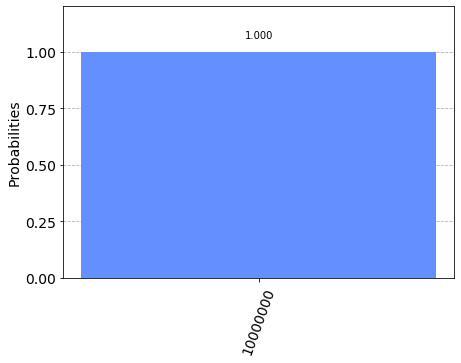

In [4]:
plot_histogram(counts_result)